### UCB1
UCB update rule:

ai <-- argmax {xa + sqrt( 2log(t)/na(t-1) ) }


In [1]:
import numpy as np

class Environment():
    def __init__(self, n_arms, probabilities):
        self.n_arms = n_arms
        self.probabilities = probabilities

    def round(self, pulled_arm):
        return np.random.binomial(1, self.probabilities[pulled_arm])

In [9]:
import numpy

class Learner():
    def __init__(self, n_arms):
        self.n_arms = n_arms 
        self.t = 0  #Time 
        self.rewards_per_arm = x = [[] for i in range(n_arms)]
        self.collected_rewards = []
    
    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards.append(reward)

class TS_Learner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.beta_parameters = np.ones((n_arms, 2))

    def pull_arm(self):
        return np.argmax(np.random.beta(self.beta_parameters[: , 0], self.beta_parameters[:, 1]))

    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        self.beta_parameters[pulled_arm, 0] = self.beta_parameters[pulled_arm, 0] + reward
        self.beta_parameters[pulled_arm, 1] = self.beta_parameters[pulled_arm , 1] + 1 - reward


class Greedy_Learner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.expected_rewards = np.zeros(n_arms)

    def pull_arm(self):
        if(self.t < self.n_arms):
            return self.t
        idxs = np.argwhere(self.expected_rewards == self.expected_rewards.max()).reshape(-1)  #Get all the indxs with the maximum value
        pulled_arm = np.random.choice(idxs)
        return pulled_arm
    
    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        self.expected_rewards[pulled_arm] = (self.expected_rewards[pulled_arm] * (self.t -1) + reward) / self.t

class UCB1(Learner):

    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.confidence = np.zeros(n_arms)

    def pull_arm(self):
        if self.t < self.n_arms:
            return self.t 

        upper_bound = self.empirical_means + self.confidence
        return np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    
    def update(self, pulled_arm, reward):
        self.t += 1
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards.append(reward)
        self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm] * (self.t-1) + reward)/self.t
        for a in range(self.n_arms):
            number_pulled = max(1, len(self.rewards_per_arm[a]) ) 
            self.confidence[a] = (2*np.log(self.t) /number_pulled)**0.5

In [15]:
p = np.array([0.1 , 0.8 , 0.3])
n_arms = len(p)
opt = np.max(p)

T = 1000 
n_experiment = 100
ts_rewards_per_experiment = []
gr_rewards_per_experiment = []
ucb1_rewards_per_experiment = []

for e in range(n_experiment):
    env = Environment(n_arms = n_arms, probabilities = p)
    ts_learner = TS_Learner(n_arms = n_arms)
    gr_learner = Greedy_Learner(n_arms = n_arms)
    ucb1_learner = UCB1(n_arms = n_arms)
    for t in range(T):
        #TS learner 
        pulled_arm = ts_learner.pull_arm()
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward)

        #Gr learner 
        pulled_arm = gr_learner.pull_arm()
        reward = env.round(pulled_arm)
        gr_learner.update(pulled_arm, reward)

        #UCB1 learner 
        pulled_arm = ucb1_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb1_learner.update(pulled_arm, reward)
    
    ts_rewards_per_experiment.append(ts_learner.collected_rewards)
    gr_rewards_per_experiment.append(gr_learner.collected_rewards)
    ucb1_rewards_per_experiment.append(ucb1_learner.collected_rewards)


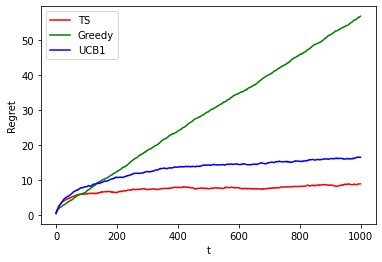

In [16]:
import matplotlib.pyplot as plt 

plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis = 0)) , 'r')
plt.plot(np.cumsum(np.mean(opt - gr_rewards_per_experiment, axis = 0)) , 'g')
plt.plot(np.cumsum(np.mean(opt - ucb1_rewards_per_experiment, axis = 0)) , 'b')
plt.legend(["TS" , "Greedy", "UCB1"])
plt.show()